In [5]:
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib.colors import LogNorm
import copy
from hessian import *

# Dimer

In [6]:
dimer_wavenumbers = get_wavenumbers("dimer_normal_modes.molden")
dimer_frequencies = wavenumber_to_frequency(dimer_wavenumbers)

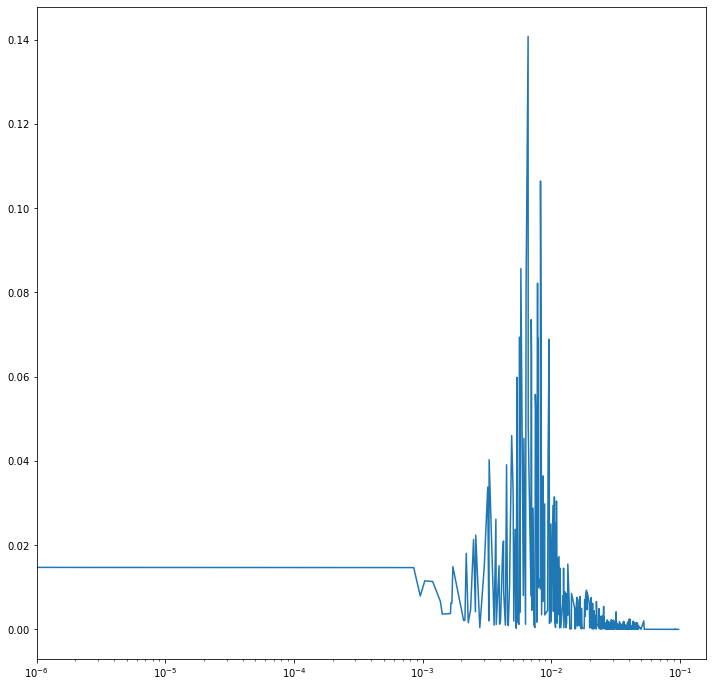

In [8]:
fig, ax = plt.subplots()

n_atoms = 158
n_modes = 3 * n_atoms - 6

Mg_index = 0

all_displacements = get_all_displacements("dimer_normal_modes.molden", n_atoms, n_modes)

ax.plot(dimer_frequencies, all_displacements[Mg_index])

ax.set_xlim(1e-6, 0.16)

ax.set_xscale('log')

fig.set_size_inches(12,12)

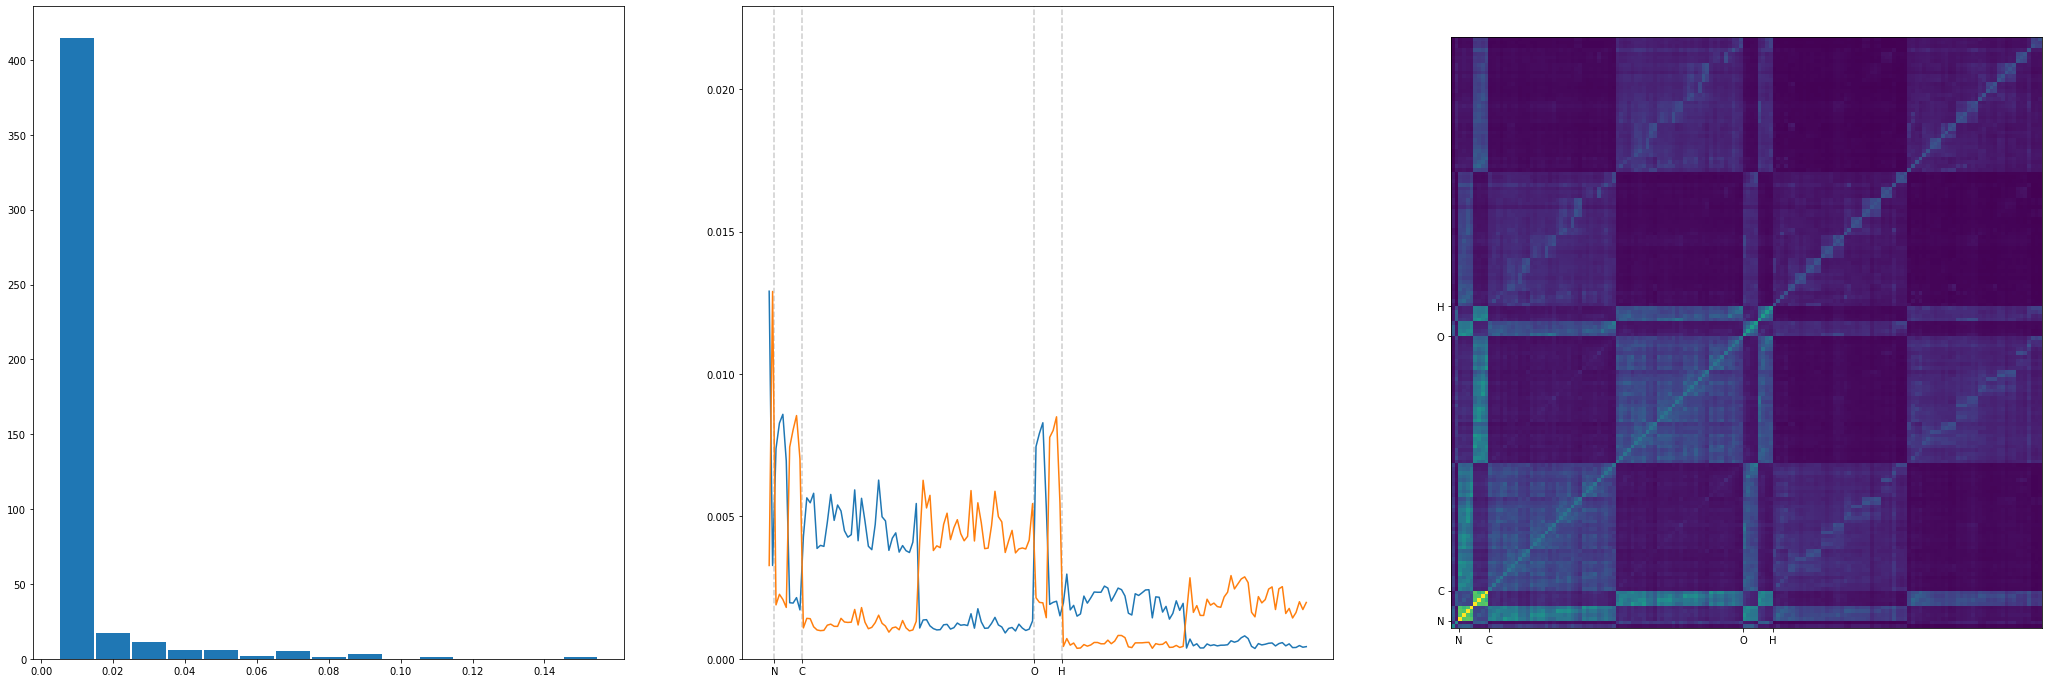

In [14]:
fig, ax = plt.subplots(1, 3)

symbols = read_symbols("dimer.xyz")

Mg_indices = np.array([enum for enum, x in enumerate(symbols) if x == "Mg"])
N_indices = np.array([enum for enum, x in enumerate(symbols) if x == "N"])
C_indices = np.array([enum for enum, x in enumerate(symbols) if x == "C"])
O_indices = np.array([enum for enum, x in enumerate(symbols) if x == "O"])
H_indices = np.array([enum for enum, x in enumerate(symbols) if x == "H"])

Mg_avg_disp= all_displacements[Mg_indices].max()
N_avg_disp = all_displacements[N_indices].max()
C_avg_disp = all_displacements[C_indices].max()
O_avg_disp = all_displacements[O_indices].max()
H_avg_disp = all_displacements[H_indices].max()

normalized_displacements = copy.copy(all_displacements)

normalized_displacements[Mg_indices] /= Mg_avg_disp
normalized_displacements[N_indices] /= N_avg_disp
normalized_displacements[C_indices] /= C_avg_disp
normalized_displacements[O_indices] /= O_avg_disp
normalized_displacements[H_indices] /= H_avg_disp

grouped_symbols = np.concatenate((Mg_indices, N_indices, C_indices, O_indices, H_indices))

normalized_displacements = normalized_displacements[grouped_symbols]

bins = np.linspace(0, 0.15, 16)
his = np.histogram(all_displacements[Mg_index], bins=bins)

ax[0].bar(his[1][1:], his[0], width=0.15/len(bins), align='center')
ax[0].set_xticks(bins[::2])

Mg_displacements = np.where(all_displacements[Mg_index] > 0.0)[0]

correlation = np.zeros((n_atoms, n_atoms))

for i in Mg_displacements:
    correlation += np.outer(normalized_displacements[:,i], normalized_displacements[:,i])
    
correlation /= len(Mg_displacements)

cax = ax[2].imshow(correlation, origin='lower', cmap=plt.get_cmap('viridis'))#, norm=LogNorm(vmin=0.0001, vmax=20))
    
#fig.colorbar(cax)

# number of each element --  Mg: 2, N: 8, C: 68, O: 8, H: 72
# cumulative -- 2, 10, 78, 86, 158

symbol_ticks = [1.5, 9.5, 77.5, 85.5]

ax[2].set_xticks(symbol_ticks)
ax[2].set_xticklabels(symbol_labels)

ax[2].set_yticks(symbol_ticks)
ax[2].set_yticklabels(symbol_labels)

ax[1].plot(correlation[0])
ax[1].plot(correlation[1])
ax[1].set_xticks(symbol_ticks)
ax[1].set_xticklabels(symbol_labels)

ax[1].vlines(symbol_ticks, color='black', linestyle='--', ymin=0, ymax=max(correlation[0])+0.01, alpha=0.2)
ax[1].set_ylim(0, max(correlation[0])+0.01)

fig.set_size_inches(36,12)